# Gold Price Prediction

## Overview

This project focuses on developing a predictive model for gold prices using machine learning techniques. The problem statement involves forecasting the gold price, represented by the GLD column in the dataset, based on historical financial indicators. The objectives are to explore the data, preprocess it, engineer features, build and evaluate models, and provide insights into factors influencing gold prices.

## Introduction and Library Loading

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
np.random.seed(42)

## Data Loading and Exploration

        Date          SPX        GLD        USO     SLV   EUR/USD
0 2008-01-02  1447.160034  84.860001  78.470001  15.180  1.471692
1 2008-01-03  1447.160034  85.570000  78.370003  15.285  1.474491
2 2008-01-04  1411.630005  85.129997  77.309998  15.167  1.475492
3 2008-01-07  1416.180054  84.769997  75.500000  15.053  1.468299
4 2008-01-08  1390.189941  86.779999  76.059998  15.590  1.557099
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2290 non-null   datetime64[ns]
 1   SPX      2290 non-null   float64       
 2   GLD      2290 non-null   float64       
 3   USO      2290 non-null   float64       
 4   SLV      2290 non-null   float64       
 5   EUR/USD  2290 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 107.5 KB
                                Date          SPX          GLD          USO  

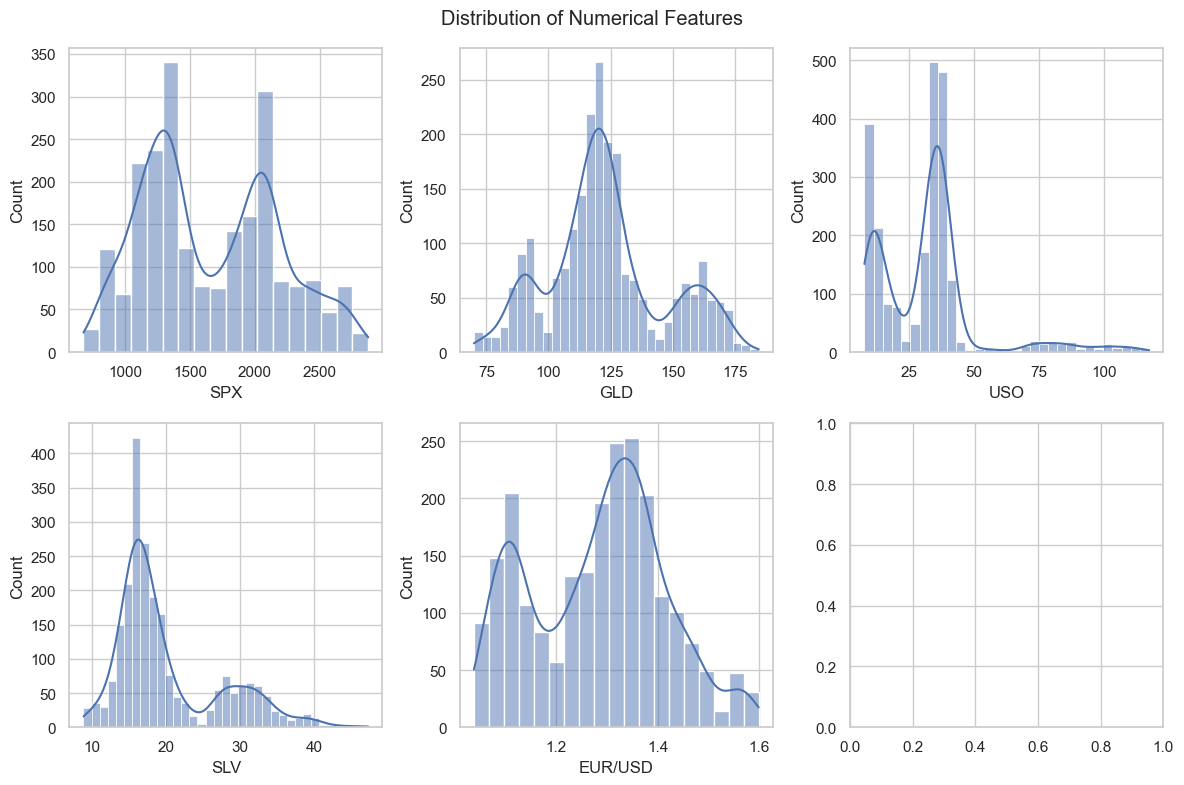

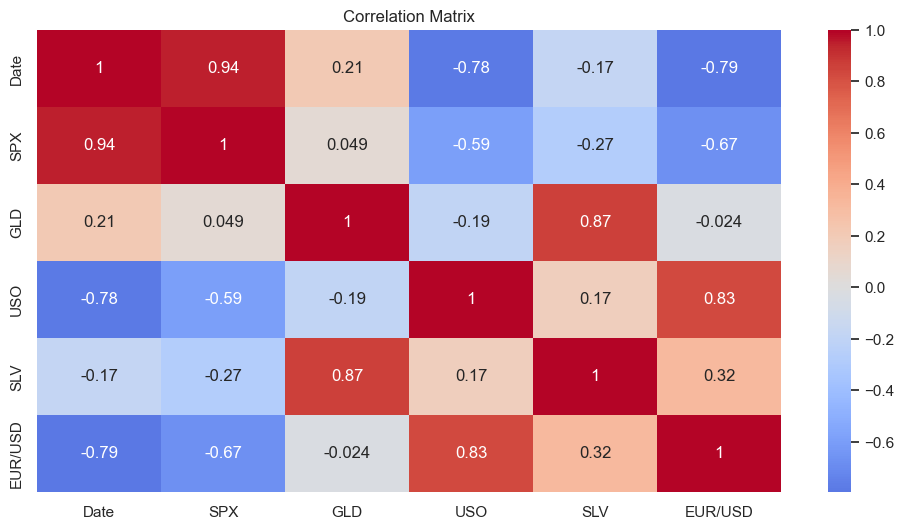

In [32]:
url = "https://drive.google.com/uc?id=1Yf_yHz1JoaCPEmlHqos3b3a4a4XxkVG6"
try:
  dataset = pd.read_csv(url, parse_dates=["Date"])
except Exception as e:
  print(f"Error loading data: {e}")
  dataset = pd.read_csv("gold-data.csv", parse_dates=["Date"])

print(dataset.head())

dataset.info()

print(dataset.describe())

print(dataset.isna().sum().sort_values(ascending=False))

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Distribution of Numerical Features')
columns = ['SPX', 'GLD', 'USO', 'SLV', 'EUR/USD']
for i, col in enumerate(columns):
  sns.histplot(dataset[col], kde=True, ax=axs[i//3, i%3])
plt.tight_layout()
plt.show()

correlation = dataset.corr()
plt.figure(figsize=(12, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

> **Initial observations:** The dataset has no missing values. GLD shows a positive correlation with SLV (high), suggesting potential multicollinearity. Distributions indicate skewness in USO, which may require transformation. Outliers are visible in box plots (added in EDA).

## Data Cleaning and Preprocessing

In [33]:
dataset.drop('SLV', axis=1, inplace=True)

dataset['USO'] = np.sqrt(dataset['USO'])

def cap_outliers(column):
  lower_limit = column.quantile(0.05)
  upper_limit = column.quantile(0.95)
  column = np.clip(column, lower_limit, upper_limit)
  return column

numerical_cols = ['SPX', 'GLD', 'USO', 'EUR/USD']
dataset[numerical_cols] = dataset[numerical_cols].apply(cap_outliers)

print(dataset.describe())

scaler = StandardScaler()
dataset[numerical_cols[:-1]] = scaler.fit_transform(dataset[numerical_cols[:-1]])

                                Date          SPX          GLD          USO  \
count                           2290  2290.000000  2290.000000  2290.000000   
mean   2013-03-17 08:23:41.135371008  1652.262616   122.815812     5.366897   
min              2008-01-02 00:00:00   898.823489    86.816000     3.160538   
25%              2010-08-20 00:00:00  1239.874969   109.725000     3.792097   
50%              2013-03-13 12:00:00  1551.434998   120.580002     5.819794   
75%              2015-10-25 00:00:00  2073.010070   132.840004     6.150407   
max              2018-05-16 00:00:00  2588.071045   166.523004     8.830510   
std                              NaN   502.795541    22.271625     1.496463   

           EUR/USD  
count  2290.000000  
mean      1.281434  
min       1.073975  
25%       1.171313  
50%       1.303297  
75%       1.369971  
max       1.491295  
std       0.125009  


## Feature Engineering

In [34]:
dataset['GLD_MA20'] = dataset['GLD'].rolling(window=20).mean()

features = ['SPX', 'USO', 'EUR/USD']
X = dataset[features]
y = dataset['GLD']

## Exploratory Data Analysis (EDA)

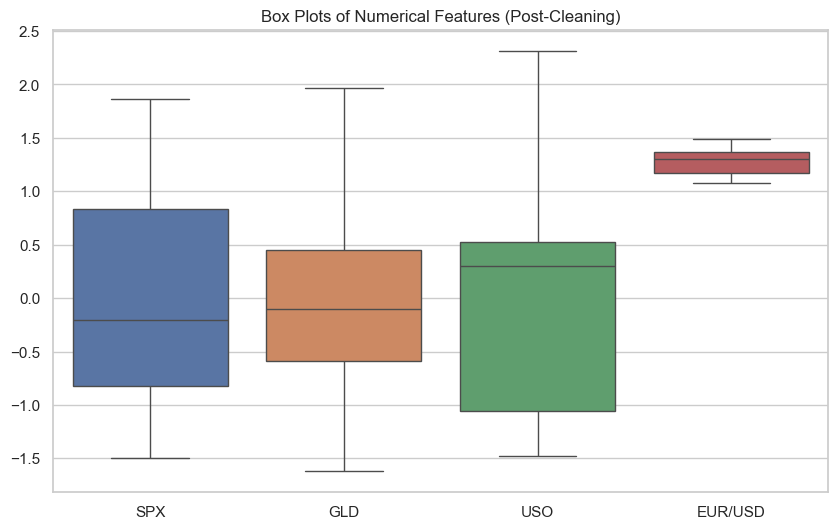

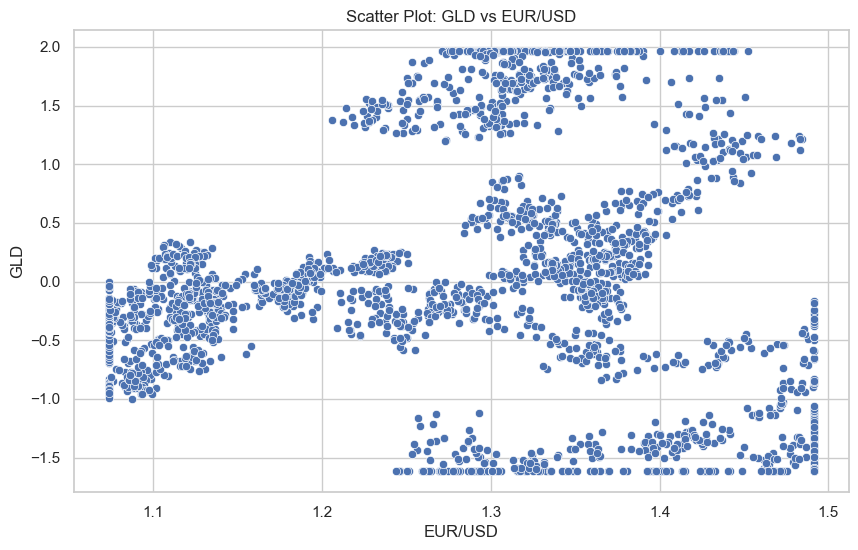

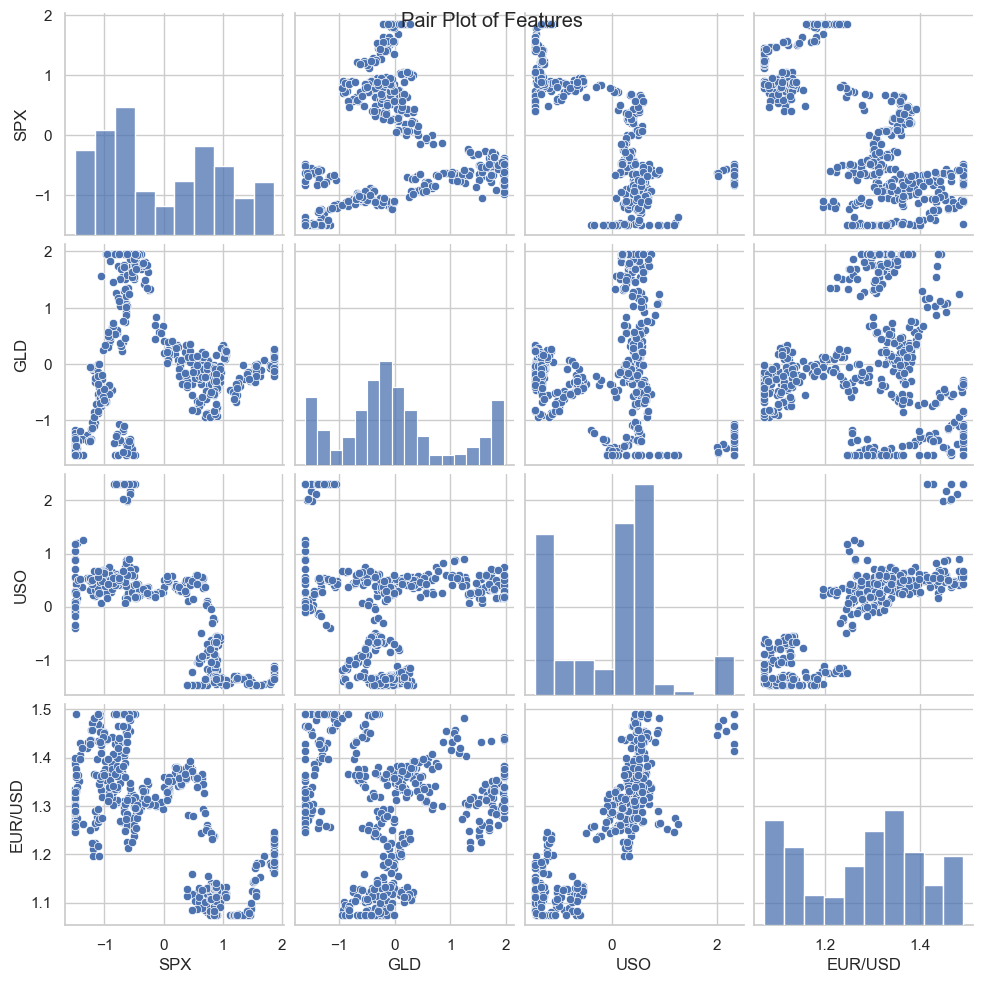

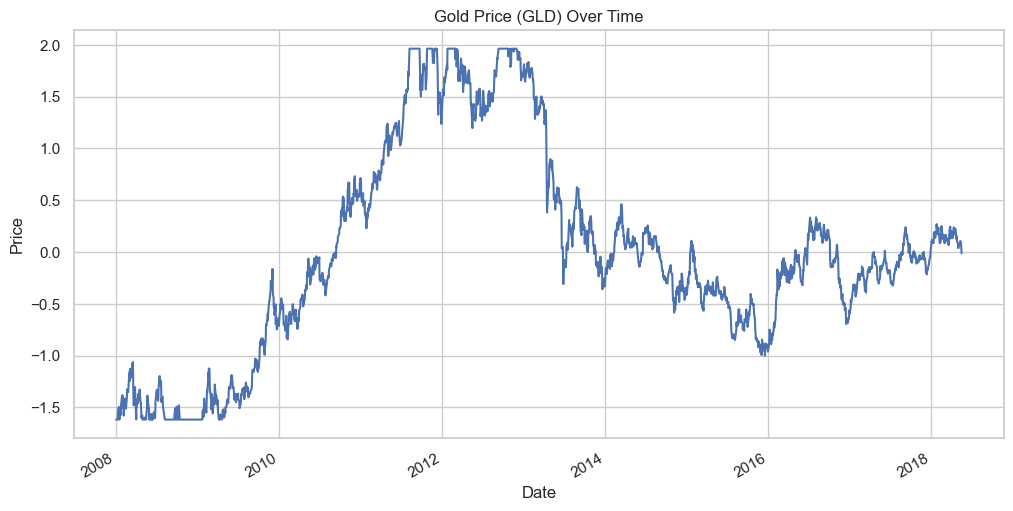

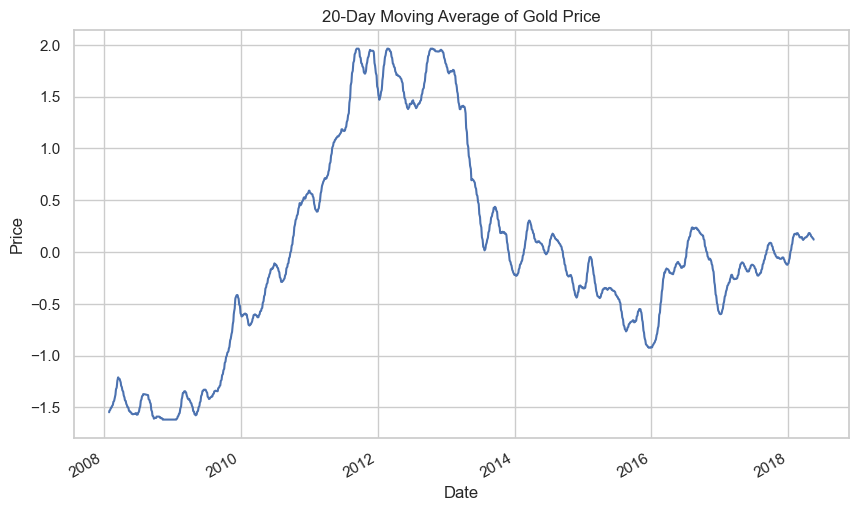

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset[numerical_cols])
plt.title('Box Plots of Numerical Features (Post-Cleaning)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=dataset['EUR/USD'], y=dataset['GLD'])
plt.title('Scatter Plot: GLD vs EUR/USD')
plt.show()

sns.pairplot(dataset[numerical_cols + ['Date']].sample(500))
plt.suptitle('Pair Plot of Features')
plt.show()

dataset.set_index('Date', inplace=True)
plt.figure(figsize=(12, 6))
dataset['GLD'].plot()
plt.title('Gold Price (GLD) Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

plt.figure(figsize=(10, 6))
dataset['GLD_MA20'].plot()
plt.title('20-Day Moving Average of Gold Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
dataset.reset_index(inplace=True)

> **Insights:** Post-transformation, distributions are more normal. Scatter plots confirm linear trends. Time series shows periods of sharp increases, potentially linked to economic events.

## Modeling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso_pipeline = make_pipeline(PolynomialFeatures(degree=2), Lasso(max_iter=10000))
lasso_params = {'lasso__alpha': [0.01, 0.1, 1]}
lasso_grid = GridSearchCV(lasso_pipeline, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)

rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)

xgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
xgb_grid = GridSearchCV(XGBRegressor(random_state=42, objective='reg:squarederror'), xgb_params, cv=5, scoring='neg_mean_squared_error')
xgb_grid.fit(X_train, y_train)

## Evaluation

           Model  R² Score       MSE
0          Lasso  0.449306  0.550020
1  Random Forest  0.958847  0.041103
2        XGBoost  0.958984  0.040966


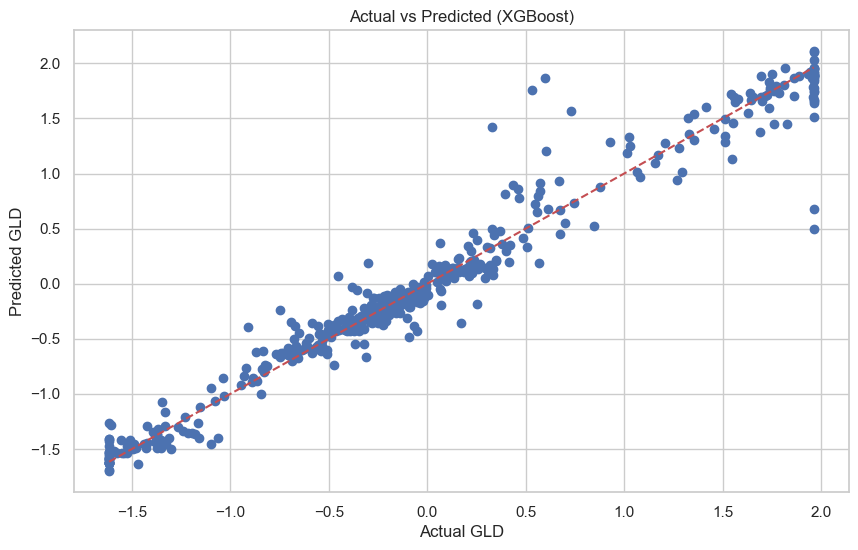

In [37]:
def evaluate_model(model, X_test, y_test):
  y_pred = model.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  return r2, mse, y_pred

lasso_r2, lasso_mse, lasso_pred = evaluate_model(lasso_grid.best_estimator_, X_test, y_test)
rf_r2, rf_mse, rf_pred = evaluate_model(rf_grid.best_estimator_, X_test, y_test)
xgb_r2, xgb_mse, xgb_pred = evaluate_model(xgb_grid.best_estimator_, X_test, y_test)

results = pd.DataFrame({
  'Model': ['Lasso', 'Random Forest', 'XGBoost'],
  'R² Score': [lasso_r2, rf_r2, xgb_r2],
  'MSE': [lasso_mse, rf_mse, xgb_mse]
})

print(results)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Actual vs Predicted (XGBoost)')
plt.xlabel('Actual GLD')
plt.ylabel('Predicted GLD')
plt.show()

> **Discussion:** XGBoost shows highest R², indicating best fit.

## Conclusion and Recommendations

| Aspect | Description |
|--------|-------------|
| Conclusion | Successfully built models to predict gold prices, with XGBoost achieving the best performance. |
| Key Insights | Currency exchange (EUR/USD) strongly influences gold prices, aligning with economic theory. Objectives met with a reproducible pipeline. |
| Practical Applications | Investment decision support. |
| Ethical Considerations | Predictions should not be the sole basis for financial decisions; potential biases in historical data may reflect market inequalities. |